# Image Classification model with Fastai: LSE vowels

**Source:** [Multi-label classification](https://docs.fast.ai/tutorial.vision.html#multi-label-classification)<br>
**Author:** Vanessa Alvear <br>
**Date created:** 2024/02/23<br>
**Last modified:** 2024/02/23<br>
**Description:** Training an image classifier using a pre-trained network on the vowels from the Spanish Sign Language (Lengua de Signos Española - LSE ).

# Introduction

In the next notebook, we are going to create a classification model for 5 hand gestures such as ✌ and 👌, for the vowels of the Spanish Sign Language (Lengua de Signos Española - LSE). To do so, we use the library [fastAI](https://www.fast.ai/). For the data, we create a dataset from scratch. In the next figure, we can see the signs of the vowels from LSE.

# Goal

Create an Image Classificator for the Vowels of the Spanish Sign Language (LSE). This model is going to use to integrate it with a Hand Detection model using the MediaPipe library in Python. Then, we implement a recognition system in real-time for the vowels LSE.

# Dataset: vowelsLSE

It was created on May, 2023 in the University of La Rioja. It consists of RGB images of 5 different gestures in JPG format. It contains three folders, one for training `train` (2423 images), one for testing `test` (692 images), one for validation (346 images) for a total of 3461 images. It contains 5 classes. The images can be classified into: 
  - A (332 (right hand) 335 (left hand), total images: 667)
  - E (377 (right hand) 393 (left hand), total images: 770)
  - I (333 (right hand) 335 (left hand), total images: 668)
  - O (340 (right hand) 338 (left hand), total images: 678)
  - U (334 (right hand) 344 (left hand), total images: 678)
  
The images are 400 x 400 in size and have a white background so that they are the same size.

**Observation:** Here we are going to mention the test dataset as **Original test data**.

In [1]:
from PIL import Image

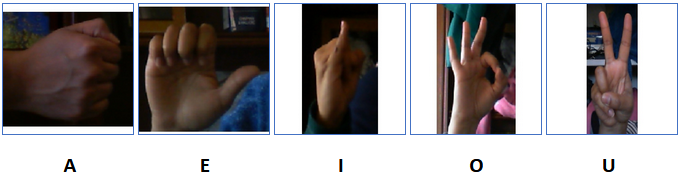

In [2]:
Image.open("images/vowels-lse-1.png")

# New dataset for test

## Dataset: vowelsLSE_new_test

It was created on Jan, 2024 in the University of La Rioja. It consists of RGB images of 5 different gestures in JPG format from five different people in different days, and in this data there is not information of the person who created the train dataset. This folder contains two subfolders, one for testing `test` (197 images), and the other one for `train` which is the same than the previous dataset. We collected a total of 197 images where it can be classified into: 

  - A (21 (right hand) 21 (left hand), total images: 42)
  - E (22 (right hand) 15 (left hand), total images: 37)
  - I (21 (right hand) 20 (left hand), total images: 41)
  - O (18 (right hand) 20 (left hand), total images: 38)
  - U (21 (right hand) 18 (left hand), total images: 39)
  
The images are 400 x 400 in size. They have a white background to make them in the same size and this process was made in local.

**Observation:** The `train` folder here, has the same images that the dataset vowelsLSE, a total of 2423 images. This might be added to this folder, because when we are creating the `DataBlock` structure for the data provided it in the `DataLoader`, we use an object of class `GrandparentSplitter` there is necessary gives the partition of the dataset in train and test, to be selected the `test` data, in our case.

**Observation:** Here we are going to mention the test dataset as **New test data**.

# Libraries

We import the necessary libraries 

We define the GPU to be used

In [3]:
%env CUDA_VISIBLE_DEVICES = 0

env: CUDA_VISIBLE_DEVICES=0


In [4]:
from fastai.vision.all import *
import fastai

In [5]:
fastai.__version__

'2.7.12'

In [6]:
seed = 1234

In [7]:
#Split dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import shutil
import random

import os
import numpy as np

import seaborn as sns

from sklearn.metrics import accuracy_score 

In [8]:
import timm

# Functions

In [9]:
def findCorruptedImages(path):
    """
    Count total corrupted files in a path per subfolder, if the image is not JPG format
    Parameters:
    path: directory string for data.
    """     
    for k in path:
        for filename in os.listdir(path):
            if filename.endswith('.JPG'):
                try:
                    img=Image.open(path+filename)
                    img.verify()
                except(IOError,SyntaxError)as e:
                    print('Bad file  :  '+filename)
                    count=count+1
                    print(count)

In [10]:
def countFilesPath(path, classNames, path_name):
    """
    Count total files in a path per subfolder
    Parameters:
    path: directory string for data.
    classNames: list of subdirectory names.
    path_name: name to print the source directories. Any string.
    """    
    for i in classNames:
        print("Number of files "+ path_name + str(i) +" =", len([entry for entry in os.listdir(path+'/'+ str(i)) if os.path.isfile(os.path.join(path+'/'+ str(i), entry))]))

In [11]:
def tensor_preds(listingModels, path_, dbTest_, number_bs):
    """
    Returns the prediction tensor resulting from the ensemble the list of models given 
    Parameters:
    path_     = path directory containing the test set we want to evaluate.
    learner_  = learner obtained when you train the model.
    dbTest_   = datablock which is defined previously, and contain the structured to upload the data, apply transformations, etc. 
    number_bs = integer to provide the batch size.
    """

    k = []
    lista = []
    w = []
    for i in range(len(listingModels)):
        dlsTest_ = dbTest_.dataloaders(path_, bs = number_bs)
        model = listingModels[i]
        model.dls = dlsTest_
        pred = model.get_preds()[0]
        k.append(pred) # k is the array with the predictions of each one of the models (each one is a tensor).
        m = list(zip(*k)) #  Generates tuples with the first elements of k

    for j in range(len(m)):
        mean = sum(m[j])/(len(m[0]))
        w.append(mean)
    #media = (np.sum(m[j], axis=0))/(len(m[0])) #Todos los modelos tienen el tensor del mismo tamaño por la longitud de dfTest     
    return w

# Info Dataset

Defining classes and paths

In [12]:
path_crop_data_dir  = 'vowels_crop_hands/'
path_crop_data      = Path(path_crop_data_dir)

In [13]:
full_path       = 'vowels_lse_new_data_fastai'
train_dir       = 'vowels_lse_new_data_fastai/train'
test_dir        = 'vowels_lse_new_data_fastai/test'
new_test_dir    = 'vowels_crop_hands/test'

The folders `train, test, new_test` which contains five subfolders, `A, E, I, O`,  and `U`. Each subfolder has image files for each category.

In [14]:
path         = Path(full_path)
trainPath    = Path(train_dir)
testPath     = Path(test_dir)
new_testPath = Path(new_test_dir)

We can create `path` objects that point respectively to the training set and the test set. 

Functions such as ls() can be used with the path object.

In [15]:
new_testPath.ls()

(#5) [Path('vowels_crop_hands/test/I'),Path('vowels_crop_hands/test/O'),Path('vowels_crop_hands/test/U'),Path('vowels_crop_hands/test/A'),Path('vowels_crop_hands/test/E')]

We can see the folder `test` contain 5 subfolders, one for each class.

Class list 

In [16]:
class_names = ['A', 'E', 'I', 'O', 'U']

We can count the number of files in each path

In [17]:
countFilesPath(train_dir, class_names, "trainPath_")

Number of files trainPath_A = 534
Number of files trainPath_E = 616
Number of files trainPath_I = 535
Number of files trainPath_O = 542
Number of files trainPath_U = 542


In [18]:
countFilesPath(new_test_dir, class_names, "new_testPath_")

Number of files new_testPath_A = 42
Number of files new_testPath_E = 37
Number of files new_testPath_I = 41
Number of files new_testPath_O = 38
Number of files new_testPath_U = 39


Finding corrupted data

In [19]:
findCorruptedImages(new_test_dir)

# Comparing Evaluation Results on New Test Data

Considering that the study of the models has been completed, the following results can be observed:

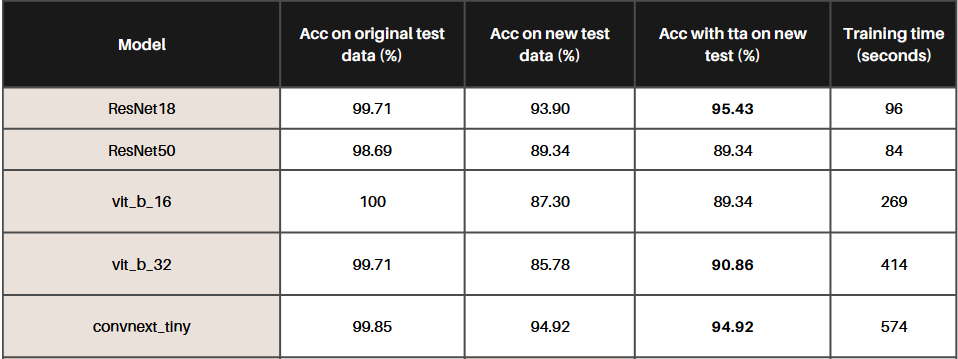

In [2]:
Image.open("results_accuracy_evaluation.png") # hd/maalvear/ModelosVowels_newData/images/resultados_accuracy_preliminares.png

It can be seen that the best ones are: ResNet-18, ViT base 32, and ConvNext tiny for testing in new data with tta technique. Therefore, we can link these models, through an **Ensemble model** after apply the tta technique.

# Loading the dataset

The dataset is loaded so that the model can be created later. This process is done in two steps. First a `DataBlock` object is constructed and then a `DataLoader` object is constructed from the `DataBlock`.

## Loading the models

To perform the Ensemble we have chosen the best three models, which have been previously trained:
    
1. Notebook # it has model ConvNext
2. Notebook # it has model ResNet-18
3. Notebook # it has model ResNet-50

Therefore, each of the models (mentioned above) have been exported as: `export_convnext_tiny_1k_224_model.pkl, export_resnet18_interaction_final.pkl`, and `export_resnet50_interaction.pkl` 

The `path` containing the export of the models is loaded.

In [20]:
path_models_dir = 'models_exports/'
path_models     = Path('models_exports/')

We import the 3 best models

In [21]:
learn_model_1 = load_learner('models_export/export_convnext_tiny_1k_224_model.pkl')

In [22]:
learn_model_2 = load_learner('models_export/export_resnet18_interaction_final.pkl')

In [23]:
learn_model_3 = load_learner('models_export/export_vit_b_32_model.pkl') 

We check if the models are loading well. So we perform the prediction on a particular image taken from the `new test set` whose class is `O`. We use the predict method on the Learners of each model for the image given and obtain the prediction.

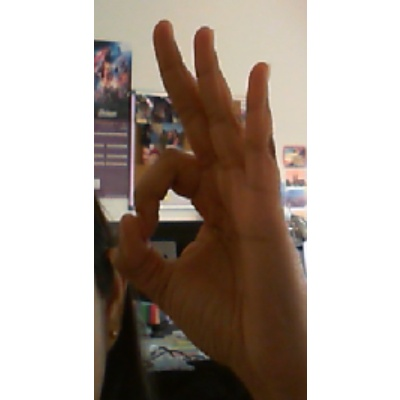

In [24]:
img = "otras_imagenes_inferencia/o_otros1.jpg"
Image.open(img)

In [25]:
learn_model_1.predict(img)

('O',
 tensor(3),
 tensor([5.8486e-05, 8.1654e-05, 7.3595e-05, 9.9967e-01, 1.1883e-04]))

In [26]:
learn_model_2.predict(img)

('O',
 tensor(3),
 tensor([9.1961e-09, 2.5470e-08, 8.3231e-08, 1.0000e+00, 9.9156e-07]))

In [27]:
learn_model_3.predict(img)

('O',
 tensor(3),
 tensor([2.3788e-06, 6.3845e-06, 1.7898e-06, 9.9988e-01, 1.1176e-04]))

Consider the list of the best models

In [28]:
models_list = [learn_model_1, learn_model_2, learn_model_3]

# Evaluating the model in the New Test Set

In order to evaluate the model in the test set we must create a new `DataBlock` and a new `DataLoader`. 


### Datablock

To start, the `DataBlock` object is constructed. 

Since there is a training set and a test set, the validation set is randomly taken from the training set using 10% of the training set. In addition, a prescaling technique and a data augmentation technique are applied. Here, it is important normalize data according to the values from ImageNet. These are the mean, and standard deviation from RGB images.

In [29]:
imagenet_stats

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [30]:
dbTest_new_test = DataBlock(blocks = (ImageBlock, CategoryBlock),
                get_items=get_image_files, 
                splitter=GrandparentSplitter(valid_name='test'), #Usamos el conjunto de test
                get_y=parent_label,
                item_tfms = Resize(256),
                batch_tfms=[*aug_transforms(size=224, min_scale=0.75,do_flip=True,flip_vert=False,
                max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                    Normalize.from_stats(*imagenet_stats)])

In the `DataBlock` object we can see that it takes as input value images and the output is the category of each of the images. In the presizing technique is considered by default the method of type ResizeMethod whose default technique is 'crop', this technique takes the images and applies this transformation to randomly crop the images to size 256. Furthermore, in the presizing, the pad_mode of type PadMode is considered whose default value is the 'reflection' technique, this technique reflects the images vertically. 

### Dataloader

Now, the next step is to build the `DataLoader` which is built from the `DataBlock` previously built, indicating the path where the images are located. In addition, we indicate the size of the batch we want to use.

In [31]:
dlsTest_new_transf= dbTest_new_test.dataloaders(path_crop_data_dir, bs=16)
dlsTest_new_res   = dbTest_new_test.dataloaders(path_crop_data_dir, bs=128)

In the data enhancement technique we observe that among the transformations applied to the images we can find: rotations, flipping the images in random directions, zooming, warping the images, brightness and [affine transformations](https://en.wikipedia.org/wiki/Affine_transformation) (a geometric transformation that preserves lines and parallelism - but not necessarily distances and angles). 

A batch of the `DataLoader` is shown below. It is convenient to check that the images and their annotations have really been loaded correctly.

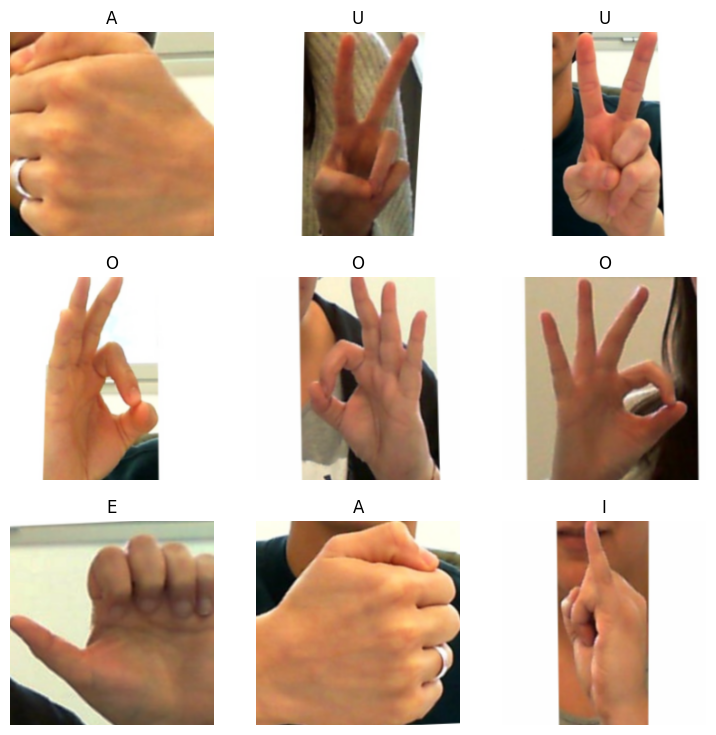

In [32]:
dlsTest_new_transf.show_batch()

To work with this DataLoader, the Learner object must be modified. Specifically its attribute dls.

In [32]:
learn_model_1.dls = dlsTest_new_transf
learn_model_2.dls = dlsTest_new_res
learn_model_3.dls = dlsTest_new_transf

Finally, the model is evaluated using the validate method and we verify that the value of the mae metric obtained in model 1 is 94.92%.

In [33]:
learn_model_1.validate()

Better model found at epoch 0 with valid_loss value: 0.9492385983467102.


(#2) [0.11635325103998184,0.9492385983467102]

In [34]:
learn_model_2.validate()

Better model found at epoch 0 with valid_loss value: 0.9390863180160522.


(#2) [0.17473815381526947,0.9390863180160522]

In [35]:
learn_model_3.validate()

Better model found at epoch 0 with valid_loss value: 0.8578680157661438.


(#2) [0.40277695655822754,0.8578680157661438]

We can also obtain the tensor of the predictions through the get_preds method, which contains two tensors, the first one indicates the value of the predictions obtained for each image and the second one, the values of the target variable.

The prediction tensor is displayed.

In [36]:
pred_model1 = learn_model_1.get_preds()

The first element has the probabilities tensor

In [37]:
pred_model1[0][:3]

tensor([[1.0073e-03, 3.0630e-04, 9.5341e-01, 4.2428e-02, 2.8516e-03],
        [6.3081e-05, 1.0618e-04, 9.9937e-01, 3.1395e-04, 1.4756e-04],
        [1.7864e-03, 9.8395e-04, 4.2511e-01, 5.6008e-01, 1.2041e-02]])

The second element has the predictions tensor, the classes where 0 is for class A, and so forth

In [38]:
pred_model1[1][:3]

tensor([2, 2, 2])

The tensor length is

In [39]:
len(pred_model1)

2

Component one and two have the same length

In [40]:
len(pred_model1[0]), len(pred_model1[1])

(197, 197)

Example learner 2

In [41]:
pred_model2 = learn_model_2.get_preds()

In [42]:
pred_model2[0][:3]

tensor([[1.4963e-04, 2.9675e-05, 8.6521e-01, 1.3383e-01, 7.8005e-04],
        [6.2334e-05, 6.3892e-04, 9.3686e-01, 6.1899e-02, 5.4265e-04],
        [4.2926e-04, 5.5519e-05, 6.8357e-01, 3.1563e-01, 3.1144e-04]])

The tensor length is

In [43]:
len(pred_model2)

2

Component one and two have the same length

In [44]:
len(pred_model2[0]), len(pred_model2[1])

(197, 197)

# Model: Ensemble without tta

In [45]:
preds1, gt_1 = learn_model_1.get_preds()
preds2, gt_2 = learn_model_2.get_preds()
preds3, gt_3 = learn_model_3.get_preds()

Now, we sum and calculate the mean of the predictions after tta technique according to the number of models, which in this case is three

In [46]:
preds_all = preds1 + preds2 + preds3
preds_all_mean = (preds_all)/3

Finally, the accuracy of the Ensemble model is

In [48]:
accuracy_score(np.argmax(preds_all_mean, axis=1), gt_1)

0.9593908629441624

Therefore, the result of the ensemble model on new test data was 95.93%.

# Model: Ensemble with tta

Now that you have seen that the model loads well and you can get your predictions. We want to apply it for each of the models and generate the Ensemble.

Next we will build the Ensemble from the ConvNex, ResNet-18, and ResNet-50 models. We want to obtain a better result using the models obtained to achieve better predictions.

## Building the model

For its construction, the predictions of each model are considered, the average of each of the entries of these values is calculated, these will be the entries of the array that will form the Ensemble.

If the process is analyzed, it can be detailed as follows: as we want to evaluate the new test set, then, the *dbTest_new* object is built, which is the *DataBlock* that allows to build the *DataLoader*. Then, the *dlsTest_new* object is constructed, which is the *DataLoader* from the new test set. Finally, from some functions that we have created, the operations are performed and the Ensemble is obtained. In this way, with the Ensemble and the ground truth, it only remains to validate it using the Accuracy metric.

To do this, we use the method `tta()` to obtain the predictions regarding the transformations applied with tta by default, because we obtain the best accuracy applying this technique.

In [49]:
preds_1, gt1 = learn_model_1.tta()
preds_2, gt2 = learn_model_2.tta()
preds_3, gt3 = learn_model_3.tta()

We validate to verify the results with tta technique

In [47]:
accuracy_score(np.argmax(preds_1, axis=1), gt1)

0.9543147208121827

In [48]:
accuracy_score(np.argmax(preds_2, axis=1), gt2)

0.9543147208121827

In [49]:
accuracy_score(np.argmax(preds_3, axis=1), gt3)

0.9137055837563451

Now, we sum and calculate the mean of the predictions after tta technique according to the number of models, which in this case is three

In [50]:
preds_all_tta = preds_1 + preds_2 + preds_3
preds_all_tta_mean = (preds_all_tta)/3

Finally, the accuracy of the Ensemble model is

In [51]:
accuracy_score(np.argmax(preds_all_tta_mean,axis=1), gt3)

0.949238578680203

Finally, the evaluation of the ensemble model with tta on new data test was 94.92%.

# Ensemble with original data without tta

In [54]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'), #Usamos el conjunto de test
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75,do_flip=True,flip_vert=False,
                  max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                         Normalize.from_stats(*imagenet_stats)])

In [55]:
dlsTest_new_transf2= dbTest.dataloaders(path, bs=16) #dlsTest = dbTest.dataloaders(path, bs=128)
dlsTest_new_res2   = dbTest.dataloaders(path, bs=128)

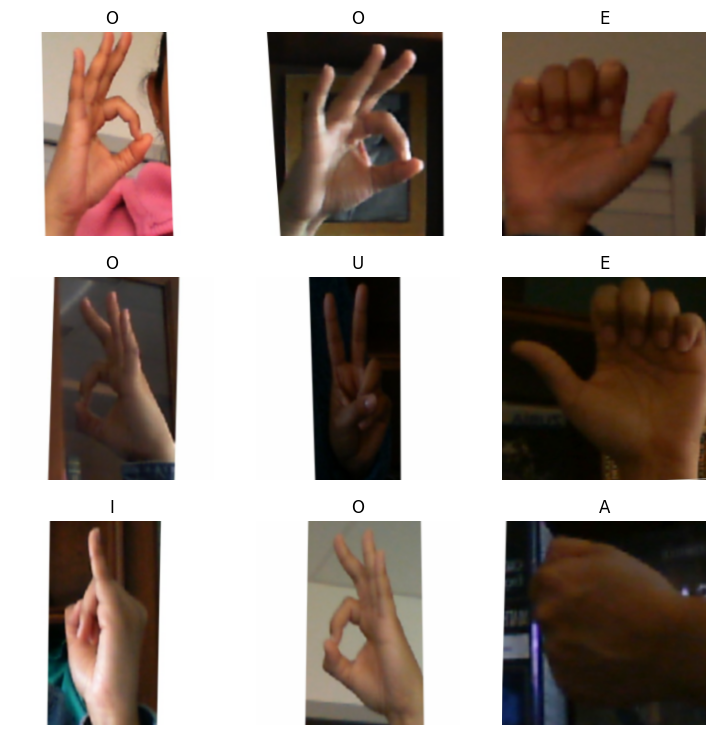

In [57]:
dlsTest_new_transf2.show_batch()

In [58]:
learn_model_1.dls = dlsTest_new_transf2
learn_model_2.dls = dlsTest_new_res2
learn_model_3.dls = dlsTest_new_transf2

In [59]:
learn_model_1.validate()

Better model found at epoch 0 with valid_loss value: 0.9985548853874207.


(#2) [0.005092020146548748,0.9985548853874207]

In [60]:
learn_model_2.validate()

Better model found at epoch 0 with valid_loss value: 0.9971098303794861.


(#2) [0.008720277808606625,0.9971098303794861]

In [61]:
learn_model_3.validate()

Better model found at epoch 0 with valid_loss value: 0.9971098303794861.


(#2) [0.005351077765226364,0.9971098303794861]

In [62]:
preds1_, gt_1_ = learn_model_1.get_preds()
preds2_, gt_2_ = learn_model_2.get_preds()
preds3_, gt_3_ = learn_model_3.get_preds()

In [63]:
accuracy_score(np.argmax(preds1_, axis=1), gt_1_)

0.9985549132947977

In [65]:
accuracy_score(np.argmax(preds2_, axis=1), gt_2_)

0.9971098265895953

In [66]:
accuracy_score(np.argmax(preds3_, axis=1), gt_3_)

0.9971098265895953

Now, we sum and calculate the mean of the predictions after tta technique according to the number of models, which in this case is three

In [67]:
preds_all_ = preds1_ + preds2_ + preds3_
preds_all_mean_ = (preds_all_)/3

Finally, the accuracy of the Ensemble model is

In [68]:
accuracy_score(np.argmax(preds_all_mean_, axis=1), gt_1_)

1.0

We can notice, using the model for different images that the model not seen before, with diffierent sizes, the classification works classifying correctly the images.

## Sources and References

Some additional references that allowed this work to be carried out

1. Affine transformations: https://en.wikipedia.org/wiki/Affine_transformation

2. Presizing and aug_aumentation: https://docs.fast.ai/vision.augment#aug_transforms